# Information Retrieval: Dense Retrieval with FAISS and Neural Reranking

Welcome to this comprehensive tutorial on modern information retrieval! In this notebook, we'll explore:

1. **MS MARCO Dataset** - Real web search queries with relevance judgments
2. **Dense Embeddings** - Neural representations for semantic search
3. **FAISS** - Fast similarity search for first-stage retrieval
4. **BM25** - Traditional keyword-based retrieval baseline
5. **Neural Reranking** - CrossEncoders for accurate result refinement
6. **PyTerrier** - Pipeline composition and experimentation framework
7. **Complete Comparison** - Sparse, Dense, and Hybrid retrieval methods
8. **Evaluation Metrics** - MRR, Recall, Precision for measuring quality

---

## 1. The Two-Stage Retrieval Pipeline

**Stage 1**: Fast candidate retrieval (FAISS/BM25) → top-100 results  
**Stage 2**: Accurate reranking (CrossEncoder) → final top-10

This is how **Google, Bing, and all modern search engines work!**

By the end, you'll understand how to build production-ready IR systems. Let's begin!

In [1]:
import os
import subprocess

# Set JAVA_HOME for PyTerrier
os.environ["JAVA_HOME"] = os.path.expanduser("~/bin/jdk-17.0.2")
os.environ["PATH"] = (
    os.path.join(os.environ["JAVA_HOME"], "bin") + ":" + os.environ.get("PATH", "")
)

# Verify
print(f"JAVA_HOME: {os.environ['JAVA_HOME']}")
print(f"javac location: {os.path.join(os.environ['JAVA_HOME'], 'bin', 'javac')}")

# Check if javac exists
print("\n" + "=" * 60)
print("JAVA VERIFICATION")
print("=" * 60)

try:
    # Check java version
    result_java = subprocess.run(["java", "-version"], capture_output=True, text=True)
    print("\njava version:")
    print(result_java.stderr.strip())
except Exception as e:
    print(f"Error finding java: {e}")

try:
    # Check javac version
    result_javac = subprocess.run(["javac", "-version"], capture_output=True, text=True)
    print("\njavac version:")
    # javac outputs to stderr
    print(
        result_javac.stderr.strip()
        if result_javac.stderr
        else result_javac.stdout.strip()
    )
except Exception as e:
    print(f"Error finding javac: {e}")

print("\n" + "=" * 60)


JAVA_HOME: /storage/home/hcoda1/9/jperez333/bin/jdk-17.0.2
javac location: /storage/home/hcoda1/9/jperez333/bin/jdk-17.0.2/bin/javac

JAVA VERIFICATION



java version:
openjdk version "17.0.2" 2022-01-18
OpenJDK Runtime Environment (build 17.0.2+8-86)
OpenJDK 64-Bit Server VM (build 17.0.2+8-86, mixed mode, sharing)

javac version:
javac 17.0.2



In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss
import pyterrier as pt
from tqdm.auto import tqdm
import random
from collections import defaultdict
import warnings

warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Initialize PyTerrier (required before use)
if not pt.started():
    pt.init()

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


Using device: cuda
PyTorch version: 2.9.1+cu128


Java started and loaded: pyterrier.java.colab, pyterrier.java, pyterrier.java.24, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipykernel_1055766/2663580073.py:27: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


## 2. The MS MARCO Dataset

**MS MARCO** (Microsoft MAchine Reading COmprehension) is one of the most important datasets in modern information retrieval.

#### Key Facts:
- **Queries**: Real anonymized Bing search queries
- **Passages**: ~8.8 million web passages from Bing search results
- **Relevance**: Human-annotated relevant passages for each query
- **Task**: Given a query, retrieve the most relevant passages

#### Why MS MARCO?

1. **Realistic**: Real user queries, not synthetic
2. **Large-scale**: Millions of passages to search through
3. **Industry standard**: Used by Google, Microsoft, Meta for IR research
4. **Benchmark**: All modern retrieval systems are evaluated on MS MARCO

#### Example:
- **Query**: "what is the difference between a tornado and a hurricane"
- **Relevant Passage**: "The main difference between a tornado and a hurricane is that a tornado forms over land while a hurricane forms over water. Tornadoes are smaller but more intense, while hurricanes are larger but less intense per area..."

For this tutorial, we'll work with a **sampled subset** to keep things fast and interactive!

---

## 3. Understanding MS MARCO Dataset Structure

### What is MS MARCO?

MS MARCO contains **real Bing search queries** paired with **relevant passages** from web pages.

Each item in the dataset has:
- **`query`**: A search question (e.g., "how do airplanes fly")
- **`passages`**: Multiple candidate passages that might answer the query
- **`is_selected`**: Labels showing which passages are relevant

### Our Strategy

We'll load the dataset **twice** for different purposes:

1. **Corpus (10K items)** → Extract **passages** → Documents to search through
2. **Queries (500 items)** → Extract **queries** → Search questions to test

Think of it like a library:
- **Corpus** = 10,000 books on shelves (documents to search)
- **Queries** = 500 questions from readers (searches to perform)

Let's load both and inspect the structure!

In [3]:
print("Loading MS MARCO dataset...")
print("This may take a few minutes on first run (dataset will be cached)...\n")

# Sample sizes
CORPUS_SIZE = 10000  # Items to extract PASSAGES from (documents to search)
QUERY_SIZE = 500  # Items to extract QUERIES from (search questions)

print("=" * 70)
print("LOADING STRATEGY")
print("=" * 70)
print(f"Corpus: {CORPUS_SIZE:,} items → Extract PASSAGES (documents)")
print(f"Queries: {QUERY_SIZE:,} items → Extract QUERIES (search questions)")
print("=" * 70 + "\n")

# Load corpus items (we'll extract passages from these)
print(f"Loading {CORPUS_SIZE:,} items for corpus...")
corpus_dataset = load_dataset("ms_marco", "v1.1", split=f"train[:{CORPUS_SIZE}]")

# Load query items (we'll extract queries from these)
print(f"Loading {QUERY_SIZE:,} items for queries...")
query_dataset = load_dataset("ms_marco", "v1.1", split=f"train[:{QUERY_SIZE}]")

print("\nDataset loaded!")
print(f"Corpus items: {len(corpus_dataset):,}")
print(f"Query items: {len(query_dataset):,}")
print("\nNext: We'll extract the actual text from these items...")


Loading MS MARCO dataset...
This may take a few minutes on first run (dataset will be cached)...

LOADING STRATEGY
Corpus: 10,000 items → Extract PASSAGES (documents)
Queries: 500 items → Extract QUERIES (search questions)

Loading 10,000 items for corpus...
Loading 500 items for queries...

Dataset loaded!
Corpus items: 10,000
Query items: 500

Next: We'll extract the actual text from these items...


In [4]:
# Inspect the dataset structure
print("=" * 80)
print("DATASET STRUCTURE INSPECTION")
print("=" * 80)

# Show one item from corpus_dataset
print("\nSAMPLE ITEM FROM CORPUS DATASET:")
print("-" * 80)
sample_corpus_item = corpus_dataset[0]

print(f"Keys in item: {list(sample_corpus_item.keys())}\n")

print("1. Query field:")
print(f"Type: {type(sample_corpus_item['query'])}")
print(f"Content: '{sample_corpus_item['query'][:100]}...'\n")

print("2. Passages field:")
print(f"Type: {type(sample_corpus_item['passages'])}")
print(f"Keys: {list(sample_corpus_item['passages'].keys())}\n")
if isinstance(sample_corpus_item["passages"], dict):
    passage_texts = sample_corpus_item["passages"]["passage_text"]
    print(f"Number of passages: {len(passage_texts)}")
    print(f"First passage: '{passage_texts[0][:150]}...'\n")

    if "is_selected" in sample_corpus_item["passages"]:
        is_selected = sample_corpus_item["passages"]["is_selected"]
        print(f"Relevance labels: {is_selected}")
        print(f"Relevant passages: {sum(is_selected)} out of {len(is_selected)}\n")

print("-" * 80)
print("\nSAMPLE ITEM FROM QUERY DATASET:")
print("-" * 80)
sample_query_item = query_dataset[0]

print(f"Query: '{sample_query_item['query']}'\n")

if "passages" in sample_query_item:
    query_passages = sample_query_item["passages"]
    if isinstance(query_passages, dict) and "passage_text" in query_passages:
        print(f"Number of candidate passages: {len(query_passages['passage_text'])}")
        print(f"First candidate: '{query_passages['passage_text'][0][:150]}...'\n")

print("=" * 80)


DATASET STRUCTURE INSPECTION

SAMPLE ITEM FROM CORPUS DATASET:
--------------------------------------------------------------------------------
Keys in item: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers']

1. Query field:
Type: <class 'str'>
Content: 'what is rba...'

2. Passages field:
Type: <class 'dict'>
Keys: ['is_selected', 'passage_text', 'url']

Number of passages: 10
First passage: 'Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing over...'

Relevance labels: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Relevant passages: 1 out of 10

--------------------------------------------------------------------------------

SAMPLE ITEM FROM QUERY DATASET:
--------------------------------------------------------------------------------
Query: 'what is rba'

Number of candidate passages: 10
First candidate: 'Since 2007, the RBA's outstanding reputation has been affected by th

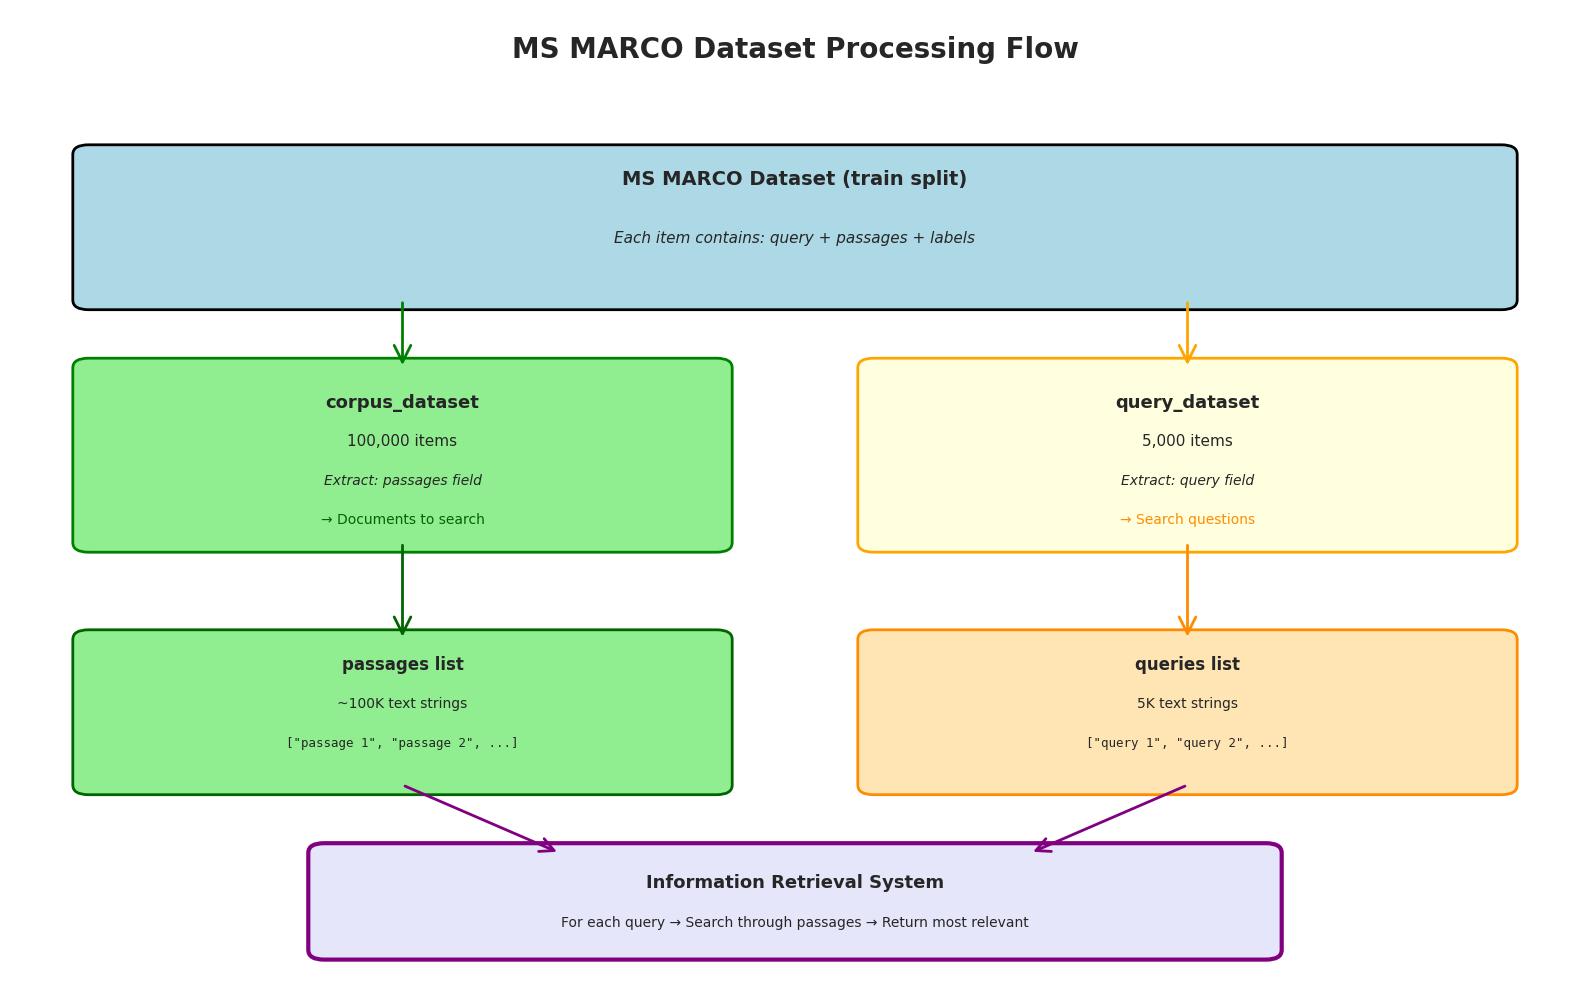


Key Takeaway:
   • We load the SAME dataset twice (different samples)
   • From corpus items: Extract passages → What to search
   • From query items: Extract queries → What to search for


In [6]:
# Create a visual representation of what we're doing
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis("off")

# Title
ax.text(
    5,
    9.5,
    "MS MARCO Dataset Processing Flow",
    fontsize=20,
    fontweight="bold",
    ha="center",
)

# MS MARCO Dataset box
dataset_box = FancyBboxPatch(
    (0.5, 7),
    9,
    1.5,
    boxstyle="round,pad=0.1",
    edgecolor="black",
    facecolor="lightblue",
    linewidth=2,
)
ax.add_patch(dataset_box)
ax.text(
    5,
    8.2,
    "MS MARCO Dataset (train split)",
    fontsize=14,
    ha="center",
    fontweight="bold",
)
ax.text(
    5,
    7.6,
    "Each item contains: query + passages + labels",
    fontsize=11,
    ha="center",
    style="italic",
)

# Split into two paths
# Left path - Corpus
corpus_box = FancyBboxPatch(
    (0.5, 4.5),
    4,
    1.8,
    boxstyle="round,pad=0.1",
    edgecolor="green",
    facecolor="lightgreen",
    linewidth=2,
)
ax.add_patch(corpus_box)
ax.text(2.5, 5.9, "corpus_dataset", fontsize=13, ha="center", fontweight="bold")
ax.text(2.5, 5.5, "100,000 items", fontsize=11, ha="center")
ax.text(2.5, 5.1, "Extract: passages field", fontsize=10, ha="center", style="italic")
ax.text(2.5, 4.7, "→ Documents to search", fontsize=10, ha="center", color="darkgreen")

# Right path - Queries
query_box = FancyBboxPatch(
    (5.5, 4.5),
    4,
    1.8,
    boxstyle="round,pad=0.1",
    edgecolor="orange",
    facecolor="lightyellow",
    linewidth=2,
)
ax.add_patch(query_box)
ax.text(7.5, 5.9, "query_dataset", fontsize=13, ha="center", fontweight="bold")
ax.text(7.5, 5.5, "5,000 items", fontsize=11, ha="center")
ax.text(7.5, 5.1, "Extract: query field", fontsize=10, ha="center", style="italic")
ax.text(7.5, 4.7, "→ Search questions", fontsize=10, ha="center", color="darkorange")

# Arrows from dataset to splits
arrow1 = FancyArrowPatch(
    (2.5, 7), (2.5, 6.3), arrowstyle="->", mutation_scale=30, linewidth=2, color="green"
)
ax.add_patch(arrow1)

arrow2 = FancyArrowPatch(
    (7.5, 7),
    (7.5, 6.3),
    arrowstyle="->",
    mutation_scale=30,
    linewidth=2,
    color="orange",
)
ax.add_patch(arrow2)

# Processed outputs
passages_box = FancyBboxPatch(
    (0.5, 2),
    4,
    1.5,
    boxstyle="round,pad=0.1",
    edgecolor="darkgreen",
    facecolor="#90EE90",
    linewidth=2,
)
ax.add_patch(passages_box)
ax.text(2.5, 3.2, "passages list", fontsize=12, ha="center", fontweight="bold")
ax.text(2.5, 2.8, "~100K text strings", fontsize=10, ha="center")
ax.text(
    2.5,
    2.4,
    '["passage 1", "passage 2", ...]',
    fontsize=9,
    ha="center",
    family="monospace",
)

queries_box = FancyBboxPatch(
    (5.5, 2),
    4,
    1.5,
    boxstyle="round,pad=0.1",
    edgecolor="darkorange",
    facecolor="#FFE5B4",
    linewidth=2,
)
ax.add_patch(queries_box)
ax.text(7.5, 3.2, "queries list", fontsize=12, ha="center", fontweight="bold")
ax.text(7.5, 2.8, "5K text strings", fontsize=10, ha="center")
ax.text(
    7.5, 2.4, '["query 1", "query 2", ...]', fontsize=9, ha="center", family="monospace"
)

# Arrows to processed
arrow3 = FancyArrowPatch(
    (2.5, 4.5),
    (2.5, 3.5),
    arrowstyle="->",
    mutation_scale=30,
    linewidth=2,
    color="darkgreen",
)
ax.add_patch(arrow3)

arrow4 = FancyArrowPatch(
    (7.5, 4.5),
    (7.5, 3.5),
    arrowstyle="->",
    mutation_scale=30,
    linewidth=2,
    color="darkorange",
)
ax.add_patch(arrow4)

# Final use case
use_box = FancyBboxPatch(
    (2, 0.3),
    6,
    1,
    boxstyle="round,pad=0.1",
    edgecolor="purple",
    facecolor="lavender",
    linewidth=3,
)
ax.add_patch(use_box)
ax.text(
    5, 0.95, "Information Retrieval System", fontsize=13, ha="center", fontweight="bold"
)
ax.text(
    5,
    0.55,
    "For each query → Search through passages → Return most relevant",
    fontsize=10,
    ha="center",
)

# Arrows to final use
arrow5 = FancyArrowPatch(
    (2.5, 2),
    (3.5, 1.3),
    arrowstyle="->",
    mutation_scale=25,
    linewidth=2,
    color="purple",
)
ax.add_patch(arrow5)

arrow6 = FancyArrowPatch(
    (7.5, 2),
    (6.5, 1.3),
    arrowstyle="->",
    mutation_scale=25,
    linewidth=2,
    color="purple",
)
ax.add_patch(arrow6)

plt.tight_layout()
plt.show()

print("\nKey Takeaway:")
print("   • We load the SAME dataset twice (different samples)")
print("   • From corpus items: Extract passages → What to search")
print("   • From query items: Extract queries → What to search for")


## 4. Understanding Relevance: Not All Passages Are Relevant!

### Important Concept

In MS MARCO, each query comes with **multiple candidate passages**, but **most are NOT relevant**!

### Example Structure

Each item looks like this:

- **Query**: "how do airplanes fly"
- **Passages**: 3 candidate passages
- **`is_selected`**: [1, 0, 0] - only the FIRST one is relevant!

| Passage | Text | `is_selected` | Status |
|---------|------|-------------|---------|
| 0 | "Airplanes fly due to lift..." | 1 | ✅ RELEVANT |
| 1 | "Book tickets online..." | 0 | ❌ NOT RELEVANT |
| 2 | "Maintenance guide..." | 0 | ❌ NOT RELEVANT |

### The `is_selected` Field

- **1** = This passage answers the query ✅ RELEVANT
- **0** = This passage does NOT answer the query ❌ NOT RELEVANT

**Only passages with `is_selected`=1 are actually relevant to the query!**

### What are Qrels?

**Qrels** (Query Relevance judgments) = A mapping that stores which documents are relevant for each query.

We extract qrels to track: "For query X, documents Y and Z are relevant"

### Why Do We Need Qrels?

**To evaluate our retrieval system later!**

Qrels let us answer:
- Did our system retrieve the relevant passages?
- How good is our ranking?

We'll extract qrels now and use them for evaluation metrics later in the notebook.

In [5]:
# Extract passages and queries with CONSISTENT ID scheme
passages = []
passage_ids = []

print("Processing passages...")

# MS MARCO v1.1 structure: item['passages'] is a dict with keys: passage_text, is_selected, url
for idx, item in enumerate(tqdm(corpus_dataset, desc="Loading passages")):
    if "passages" in item and item["passages"]:
        passages_dict = item["passages"]

        if isinstance(passages_dict, dict) and "passage_text" in passages_dict:
            passage_texts = passages_dict["passage_text"]

            if isinstance(passage_texts, list):
                for p_idx, text in enumerate(passage_texts):
                    if text:
                        passages.append(text)
                        # KEY CHANGE: Use format that matches qrels
                        passage_ids.append(f"item_{idx}_p{p_idx}")  # Consistent format!
            else:
                if passage_texts:
                    passages.append(passage_texts)
                    passage_ids.append(f"item_{idx}_p0")

print(f"\nLoaded {len(passages):,} passages")

# Process queries with MATCHING ID scheme
queries = []
query_ids = []
qrels = defaultdict(dict)

print("Processing queries...")
for idx, item in enumerate(query_dataset):
    query_text = item.get("query", "")
    if query_text:
        queries.append(query_text)
        qid = f"q_{idx}"
        query_ids.append(qid)

        # Store relevance judgments with MATCHING IDs
        if "passages" in item and isinstance(item["passages"], dict):
            if "is_selected" in item["passages"]:
                is_selected = item["passages"]["is_selected"]
                if isinstance(is_selected, list):
                    for p_idx, selected in enumerate(is_selected):
                        if selected == 1:
                            # KEY CHANGE: Use same format as passage_ids
                            doc_id = f"item_{idx}_p{p_idx}"
                            qrels[qid][doc_id] = 1

print("\nProcessed:")
print(f"Passages: {len(passages):,}")
print(f"Queries: {len(queries):,}")
print(f"Queries with relevance judgments: {len(qrels):,}")


Processing passages...


Loading passages:   0%|          | 0/10000 [00:00<?, ?it/s]


Loaded 82,193 passages
Processing queries...

Processed:
Passages: 82,193
Queries: 500
Queries with relevance judgments: 490


In [6]:
# Display sample queries and passages
print("=" * 80)
print("SAMPLE QUERIES AND PASSAGES")
print("=" * 80)

num_samples = 5
sample_indices = random.sample(range(len(queries)), min(num_samples, len(queries)))

for i, idx in enumerate(sample_indices, 1):
    print(f"\nExample {i}:")
    print(f"Query ID: {query_ids[idx]}")
    print(f"Query: {queries[idx]}")
    print(f"Length: {len(queries[idx])} characters\n")

print("\n" + "=" * 80)
print("SAMPLE PASSAGES FROM CORPUS")
print("=" * 80)

sample_passages = random.sample(range(len(passages)), min(5, len(passages)))
for i, idx in enumerate(sample_passages, 1):
    passage_text = (
        passages[idx][:200] + "..." if len(passages[idx]) > 200 else passages[idx]
    )
    print(f"\nPassage {i}:")
    print(f"ID: {passage_ids[idx]}")
    print(f"Text: {passage_text}")
    print(f"Length: {len(passages[idx])} characters")


SAMPLE QUERIES AND PASSAGES

Example 1:
Query ID: q_327
Query: salary for pvt in us army
Length: 25 characters


Example 2:
Query ID: q_57
Query: what kind of coffee pods does delonghi use?
Length: 43 characters


Example 3:
Query ID: q_12
Query: how long cooking chicken legs in the big easy
Length: 45 characters


Example 4:
Query ID: q_379
Query: what is oxymorphone
Length: 19 characters


Example 5:
Query ID: q_140
Query: What are the frustules of diatom phytoplankton composed of?
Length: 59 characters


SAMPLE PASSAGES FROM CORPUS

Passage 1:
ID: item_3886_p4
Text: There are three types of muscles: 1  Smooth muscle or involuntary muscle consists of spindle shaped muscle cells found within the walls of organs and structures such as the esophagus, stomach, intesti...
Length: 549 characters

Passage 2:
ID: item_3540_p5
Text: blind spot. The beginning of the optic nerve in the retina is called the optic nerve head or optic disc. Since there are no photoreceptors (cones and rods) in the

## 5. Why Dataset Statistics Matter

### Understanding Query & Passage Lengths

Knowing the **length** of queries and passages is crucial for several reasons:

#### 1. Model Constraints

**Embedding models have maximum sequence lengths:**
- Our model: `multi-qa-MiniLM-L6` has max length = **512 tokens**
- If passages are longer → they get **truncated** (information lost!)
- If most passages are 1000 chars but model only handles 512 tokens → problem!

**Example:**
- Average passage: 600 characters ≈ 150 words ≈ 200 tokens ✅ Fits!
- Long passage: 3000 characters → Gets cut off ❌ Loses information

#### 2. Performance & Speed

**Longer texts = Slower processing:**
- Embedding 100-word passages: Fast
- Embedding 1000-word passages: 10x slower!

Knowing average length helps us estimate:
- How long will encoding take?
- Do we need batch processing?
- Should we split long passages?

#### 3. Understanding Search Behavior

**Query length tells us about search patterns:**
- Short queries (2-3 words): "airplane flight" → Keyword search
- Long queries (10+ words): "how do airplanes generate enough lift to stay in the air" → Natural questions

This helps us choose the right model and approach!

#### 4. Quality Control

**Statistics reveal data issues:**
- Passages with 0 characters? → Data cleaning needed
- Queries with 500+ characters? → Probably spam or errors
- Very short passages (< 10 chars)? → Not useful for retrieval

#### 5. Comparison Baseline

**Know what's "normal" for your dataset:**
- If retrieval suddenly slows down → Check if new data has longer passages
- If accuracy drops → Maybe new queries are much longer/shorter than training data

**Without stats:** You might pick a model that's too small or waste money on one that's too large!

### Bottom Line

Dataset statistics = Understanding what you're working with before investing compute time!

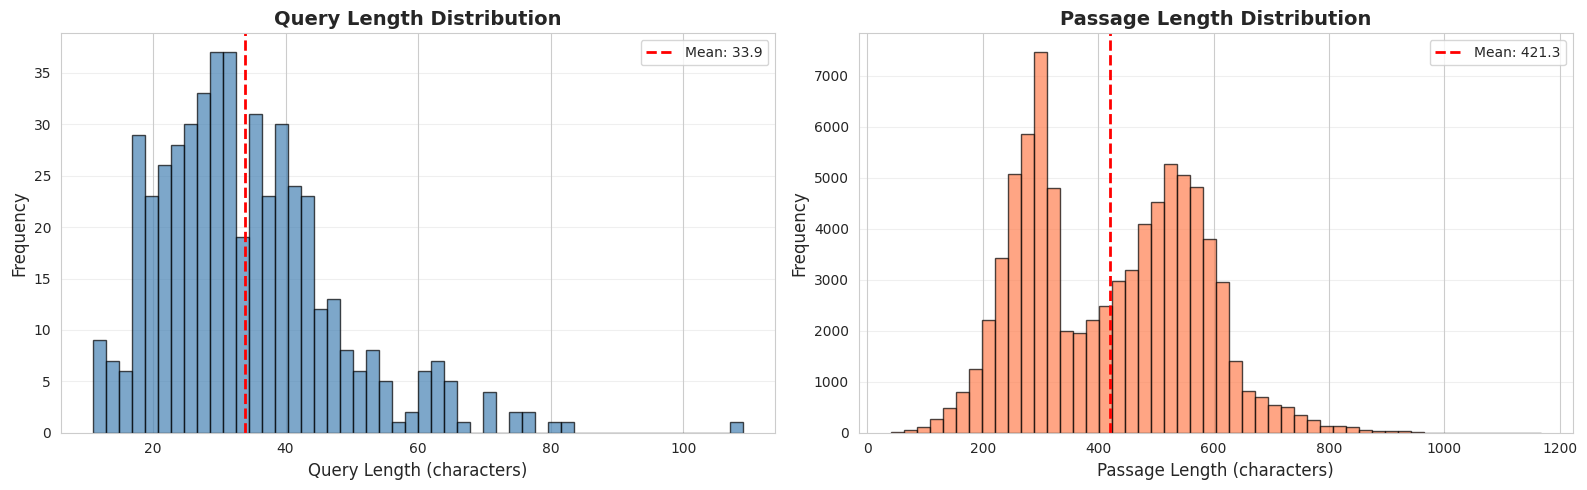


Dataset Statistics:
Queries: 500
Avg query length: 33.9 chars (6.1 words)

Passages: {len(passages):,}
Avg passage length: 421.3 chars (70.9 words)


In [9]:
# Analyze dataset statistics
query_lengths = [len(q) for q in queries]
passage_lengths = [len(p) for p in passages]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Query length distribution
axes[0].hist(query_lengths, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
axes[0].set_xlabel("Query Length (characters)", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].set_title("Query Length Distribution", fontsize=14, fontweight="bold")
axes[0].axvline(
    np.mean(query_lengths),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(query_lengths):.1f}",
)
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# Passage length distribution
axes[1].hist(passage_lengths, bins=50, color="coral", alpha=0.7, edgecolor="black")
axes[1].set_xlabel("Passage Length (characters)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].set_title("Passage Length Distribution", fontsize=14, fontweight="bold")
axes[1].axvline(
    np.mean(passage_lengths),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(passage_lengths):.1f}",
)
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDataset Statistics:")
print(f"Queries: {len(queries):,}")
print(
    f"Avg query length: {np.mean(query_lengths):.1f} chars ({np.mean([len(q.split()) for q in queries]):.1f} words)"
)
print("\nPassages: {len(passages):,}")
print(
    f"Avg passage length: {np.mean(passage_lengths):.1f} chars ({np.mean([len(p.split()) for p in passages]):.1f} words)"
)


## 6. Dense Embeddings for Semantic Search

### The Problem with Keyword Search

Traditional search (BM25, TF-IDF) relies on **exact word matching**:
- Query: "automobile repair"
- Won't match: "car maintenance" (same meaning, different words!)
- Will match: "automobile sales" (same words, different meaning!)

### Enter Dense Embeddings

**Dense embeddings** convert text into vectors that capture **semantic meaning**:
- Similar meanings → Similar vectors
- "automobile repair" and "car maintenance" will have high similarity
- Works across synonyms, paraphrases, and languages

### How It Works

1. **Encode** queries and passages into dense vectors (e.g., 384 or 768 dimensions)
2. **Measure similarity** using cosine similarity or dot product
3. **Retrieve** passages with highest similarity to query

### Model Choice: Sentence Transformers

We'll use **Sentence-BERT** models, specifically designed for semantic search:
- Pre-trained on millions of question-passage pairs
- Optimized for retrieval tasks
- Fast inference

Popular models:
- [`multi-qa-MiniLM-L6-cos-v1`](https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1) - Small, fast (384 dim) -- Good for teaching
- [`all-MiniLM-L6-v2`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) - General purpose (384 dim)
- [`all-mpnet-base-v2`](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) - High quality (768 dim)

Let's load our embedding model!

In [7]:
# Load sentence transformer model for embeddings
# This model is specifically trained for question-answering retrieval!
model_name = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"
print(f"Loading embedding model: {model_name}")
print("This may take a minute on first run...\n")

# Load model
embedding_model = SentenceTransformer(model_name, device=device)

print("Model loaded successfully!")
print(f"\n{'=' * 60}")
print("MODEL INFORMATION")
print(f"{'=' * 60}")

# Model info
print(f"Model: {model_name}")
print(f"Embedding Dimension: {embedding_model.get_sentence_embedding_dimension()}")
print(f"Max Sequence Length: {embedding_model.max_seq_length} tokens")
print(f"Device: {embedding_model.device}")

# Count parameters
total_params = sum(p.numel() for p in embedding_model.parameters())
print(f"Total Parameters: {total_params:,}")
print(f"Model Size: ~{total_params * 4 / (1024**2):.1f} MB")

print(f"{'=' * 60}\n")


Loading embedding model: sentence-transformers/multi-qa-MiniLM-L6-cos-v1
This may take a minute on first run...



Model loaded successfully!

MODEL INFORMATION
Model: sentence-transformers/multi-qa-MiniLM-L6-cos-v1
Embedding Dimension: 384
Max Sequence Length: 512 tokens
Device: cuda:0
Total Parameters: 22,713,216
Model Size: ~86.6 MB



In [13]:
# Test the embedding model with sample texts
test_query = "how do airplanes fly"
test_passages = [
    "Airplanes fly because of lift generated by air flowing over wings.",
    "The principles of aerodynamics explain how aircraft achieve flight.",
    "Pizza is a popular Italian food with cheese and tomato sauce.",
    "Python is a programming language used for data science.",
]

print(f"Test Query: '{test_query}'\n")

# Encode
query_emb = embedding_model.encode([test_query], convert_to_tensor=True)
passage_embs = embedding_model.encode(test_passages, convert_to_tensor=True)

# Compute similarities
similarities = torch.nn.functional.cosine_similarity(query_emb, passage_embs)

print("Similarity Scores (higher = more relevant):\n")
for i, (passage, score) in enumerate(
    sorted(zip(test_passages, similarities), key=lambda x: x[1], reverse=True), 1
):
    bar = "█" * int(score * 50)
    print(f"{i}. Score: {score:.4f} {bar}")
    print(f"   {passage}\n")

print(
    "Notice: Semantically related passages get higher scores, even without word overlap!"
)


Test Query: 'how do airplanes fly'



Similarity Scores (higher = more relevant):

1. Score: 0.8033 ████████████████████████████████████████
   Airplanes fly because of lift generated by air flowing over wings.

2. Score: 0.6838 ██████████████████████████████████
   The principles of aerodynamics explain how aircraft achieve flight.

3. Score: 0.0551 ██
   Pizza is a popular Italian food with cheese and tomato sauce.

4. Score: 0.0037 
   Python is a programming language used for data science.

Notice: Semantically related passages get higher scores, even without word overlap!


In [8]:
# Encode all passages into embeddings
# This is the computationally expensive part! will take ~1min on GPU and much longer on CPU...
print(f"Encoding {len(passages):,} passages...")

batch_size = 32  # Adjust based on your GPU memory

# Create passage embeddings
passage_embeddings = embedding_model.encode(
    passages,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_tensor=False,  # Return numpy for FAISS
    normalize_embeddings=True,  # Normalize for cosine similarity
)
print("\nPassage embeddings created!")
print(f"Shape: {passage_embeddings.shape}")


Encoding 82,193 passages...


Batches:   0%|          | 0/2569 [00:00<?, ?it/s]


Passage embeddings created!
Shape: (82193, 384)


In [9]:
# Encode all queries into embeddings
print(f"Encoding {len(queries):,} queries...")

query_embeddings = embedding_model.encode(
    queries,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_tensor=False,
    normalize_embeddings=True,
)
print("\nQuery embeddings created!")
print(f"Shape: {query_embeddings.shape}")


Encoding 500 queries...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]


Query embeddings created!
Shape: (500, 384)


## 7. FAISS: Fast Similarity Search - Stage 1

### The Challenge

We have:
- 100,000 passages (or millions in real systems!)
- Each query needs to search ALL passages
- Computing similarity for each pair is **slow**: O(n) per query

For 1 query × 100K passages = 100K similarity computations
For 1000 queries = **100 million** computations!

### Enter FAISS

**FAISS** (Facebook AI Similarity Search) is a library for:
- **Fast** approximate nearest neighbor search
- **Scalable** to billions of vectors
- **Optimized** for GPUs
- Used in production at Meta, Google, etc.

### How FAISS Works

1. **Index Building**: Organizes vectors for fast search
2. **Query**: Returns top-K most similar vectors in milliseconds
3. **Trade-off**: Speed vs accuracy (we'll use exact search for teaching)

### Types of FAISS Indexes

- `IndexFlatL2`: Exact search (L2 distance) - Slow but accurate
- `IndexFlatIP`: Exact search (inner product/cosine) - What we'll use!
- `IndexIVFFlat`: Approximate search - Much faster for large scale
- `IndexHNSW`: Graph-based approximate search - Best accuracy/speed trade-off

For our 10K passages, exact search is fine. For millions, we'd use approximate methods.

Let's build our FAISS index!

In [10]:
print("Building FAISS index...")

# Get embedding dimension
embedding_dim = passage_embeddings.shape[1]

# Create FAISS index
# IndexFlatIP = Flat index with Inner Product (cosine similarity for normalized vectors)
index = faiss.IndexFlatIP(embedding_dim)

# Add passage embeddings to index
index.add(passage_embeddings.astype("float32"))

print("FAISS index built!")
print(f"\n{'=' * 60}")
print("INDEX INFORMATION")
print(f"{'=' * 60}")
print("Index Type: Flat (Exact Search)")
print("Similarity Metric: Inner Product (Cosine for normalized vectors)")
print(f"Embedding Dimension: {embedding_dim}")
print(f"Number of Vectors: {index.ntotal:,}")
print(f"Index Size: ~{passage_embeddings.nbytes / (1024**2):.1f} MB")
print(f"Is Trained: {index.is_trained}")
print(f"{'=' * 60}\n")
print("The index is now ready for lightning-fast retrieval!")


Building FAISS index...
FAISS index built!

INDEX INFORMATION
Index Type: Flat (Exact Search)
Similarity Metric: Inner Product (Cosine for normalized vectors)
Embedding Dimension: 384
Number of Vectors: 82,193
Index Size: ~120.4 MB
Is Trained: True

The index is now ready for lightning-fast retrieval!


In [11]:
# Perform first-stage retrieval
K = 100  # Retrieve top-100 passages per query

print("Performing first-stage retrieval...")
print(f"Retrieving top-{K} passages for {len(queries):,} queries...\n")

# Search
scores, indices = index.search(query_embeddings.astype("float32"), K)

print("Retrieval complete!")
print(f"Results shape: {indices.shape}")
print(f"Scores shape: {scores.shape}")
print(f"Total retrievals: {indices.shape[0] * indices.shape[1]:,}")


Performing first-stage retrieval...
Retrieving top-100 passages for 500 queries...



Retrieval complete!
Results shape: (500, 100)
Scores shape: (500, 100)
Total retrievals: 50,000


In [16]:
# Show sample retrieval results
num_examples = 3
sample_query_indices = random.sample(range(len(queries)), num_examples)

for example_num, qidx in enumerate(sample_query_indices, 1):
    print("=" * 80)
    print(f"EXAMPLE {example_num}")
    print("=" * 80)
    print(f"\nQuery: {queries[qidx]}\n")
    print("Top-5 Retrieved Passages:\n")

    for rank, (score, pidx) in enumerate(zip(scores[qidx][:5], indices[qidx][:5]), 1):
        passage_text = passages[pidx]
        # Truncate long passages
        if len(passage_text) > 150:
            passage_text = passage_text[:150] + "..."
        print(f"   Rank {rank} | Score: {score:.4f}")
        print(f"   {passage_text}\n")


EXAMPLE 1

Query: what are monocytes

Top-5 Retrieved Passages:

   Rank 1 | Score: 0.8505
   3D Rendering of a Monocyte. Monocytes are a type of white blood cells (leukocytes). They are the largest of all leukocytes. They are part of the innat...

   Rank 2 | Score: 0.8000
   This is taken directly from-http://www.wisegeek.com/what-are-monocytes.htm#. Monocytes are a type of leukocyte or white blood cell which play a role i...

   Rank 3 | Score: 0.7823
   Monocyte. Monocytes are produced by the bone marrow from stem cell precursors called monoblasts. Monocytes circulate in the bloodstream for about one ...

   Rank 4 | Score: 0.7675
   Monocytes are produced by the bone marrow from precursors called monoblasts, bipotent cells that differentiated from hematopoietic stem cells. Monocyt...

   Rank 5 | Score: 0.7450
   A monocyte (pictured below) is a large type of white blood cell with one large, smooth, well-defined, indented, slightly folded, oval, kidney-shaped, ...

EXAMPLE 2

Quer

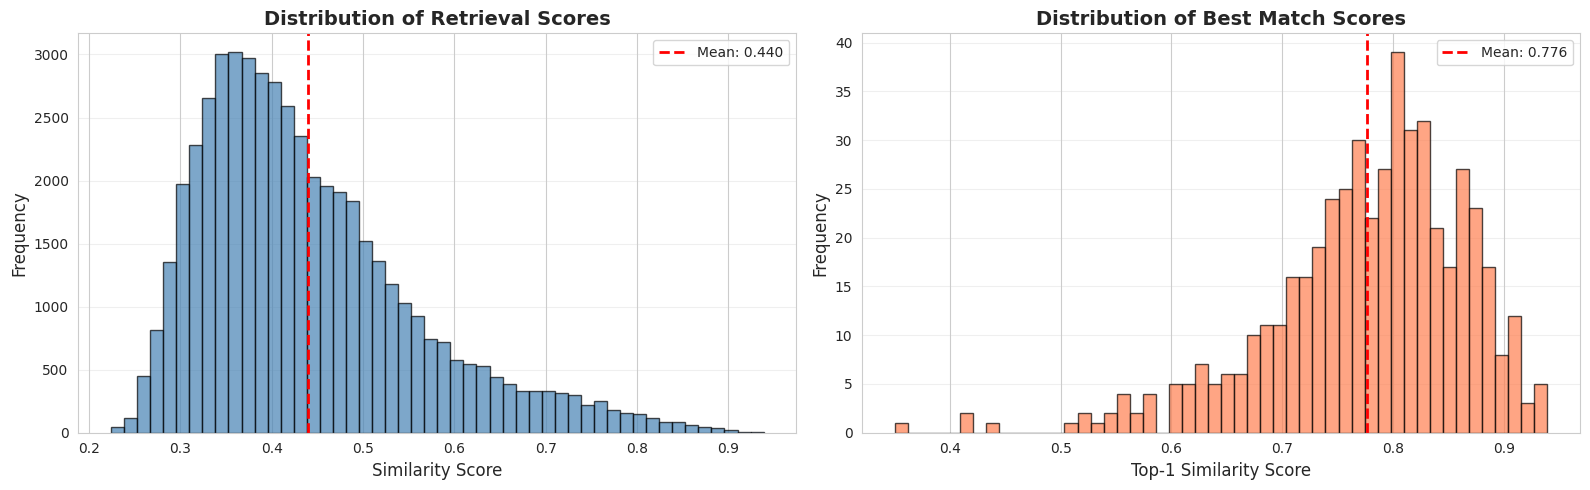


Retrieval Statistics:
Average similarity score: 0.4398
Average top-1 score: 0.7764
Min score: 0.2241
Max score: 0.9388


In [17]:
# Analyze score distributions
all_scores = scores.flatten()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Score distribution
axes[0].hist(all_scores, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
axes[0].set_xlabel("Similarity Score", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].set_title("Distribution of Retrieval Scores", fontsize=14, fontweight="bold")
axes[0].axvline(
    np.mean(all_scores),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(all_scores):.3f}",
)
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# Top-1 scores vs rank
top_scores = scores[:, 0]  # Best score for each query
axes[1].hist(top_scores, bins=50, color="coral", alpha=0.7, edgecolor="black")
axes[1].set_xlabel("Top-1 Similarity Score", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].set_title("Distribution of Best Match Scores", fontsize=14, fontweight="bold")
axes[1].axvline(
    np.mean(top_scores),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(top_scores):.3f}",
)
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRetrieval Statistics:")
print(f"Average similarity score: {np.mean(all_scores):.4f}")
print(f"Average top-1 score: {np.mean(top_scores):.4f}")
print(f"Min score: {np.min(all_scores):.4f}")
print(f"Max score: {np.max(all_scores):.4f}")


## 8. Analyzing Retrieval Score Distributions

### What Are We Looking At?

After FAISS retrieval, each query-passage pair has a **similarity score** (higher = more similar).

We're analyzing two distributions:

#### 1. All Retrieval Scores (Left Plot)
- **What**: All 500,000 similarity scores (5K queries × 100 retrieved passages each)
- **Why**: Shows the overall quality of matches
- **Good sign**: Most scores clustered around a reasonable range
- **Bad sign**: All scores near 0 (model isn't finding similarities)

#### 2. Top-1 Scores (Right Plot)
- **What**: Only the BEST match score for each query
- **Why**: Shows how confident FAISS is about top results
- **Good sign**: High top-1 scores (model is confident)
- **Bad sign**: Low top-1 scores (even best matches are weak)

### What to Look For

**Healthy retrieval:**
- Mean score: 0.3 - 0.7 (cosine similarity)
- Top-1 scores higher than average scores
- Clear separation between good and bad matches

**Poor retrieval:**
- All scores near 0 or 1 (no discrimination)
- Top-1 scores same as average (no clear winners)

This helps us understand if FAISS is finding meaningful similarities!

---

## 9. Neural Reranking: Stage 2

### Why Rerank?

**First-stage retrieval** (FAISS) is:
- ✅ Fast: Can search millions in milliseconds
- ✅ Scalable: Efficient for large corpora
- ❌ Less accurate: Uses only vector similarity

**Problem**: The bi-encoder (separate query/passage encodings) can miss subtle relevance signals.

### Enter Cross-Encoders

**Cross-encoders** (rerankers) are:
- More accurate: Process query + passage together
- Capture interactions between query and passage words
- See both texts simultaneously
- But slower: Must encode each query-passage pair

### Best of Both Worlds!

- **FAISS**: Eliminates 99.99% of irrelevant documents quickly
- **Reranker**: Accurately ranks the remaining candidates

### Models We'll Use

- **First-stage**: `multi-qa-MiniLM-L6` (bi-encoder)
- **Reranking**: `cross-encoder/ms-marco-MiniLM-L-6-v2` (cross-encoder)

Let's implement reranking!

## 10. PyTerrier: Composable IR Pipelines

**PyTerrier** is a Python framework for information retrieval research that makes it easy to build, compose, and compare retrieval systems.

#### Core Concept: Everything is a Transformer

In PyTerrier, every component is a **transformer**:
- Takes queries as input → Returns results as output
- Has a standard transform method
- Can be combined with other transformers

Think of it like Unix pipes for IR

#### Pipeline Operators

PyTerrier provides powerful operators to compose retrieval systems:

**1. Sequential operator >>** (then)

Chains transformers in sequence. Example: bm25 >> reranker
- Step 1: BM25 retrieves candidates
- Step 2: Reranker re-scores those candidates

**2. Parallel operator +** (combine)

Merges results from multiple retrievers. Example: bm25 + faiss_pt
- BM25 retrieves 100 docs
- FAISS retrieves 100 docs
- Combined: Both sets merged

**3. Cutoff operator %** (limit)

Limits number of results. Example: bm25 % 100
- Only keep top-100 results from BM25

#### Building Complex Pipelines

You can combine these operators for hybrid retrieval with reranking

#### Why PyTerrier?

- ✅ Composable: Build complex systems from simple components
- ✅ Reproducible: Standard format for sharing experiments
- ✅ Comparable: Easy to swap components and compare
- ✅ Research-grade: Used in academic IR research
- ✅ Pythonic: Works with pandas, sklearn, etc

#### In Our Notebook

We have wrapped our components as PyTerrier transformers:
- bm25 - BM25 retrieval (sparse)
- faiss_pt - FAISS retrieval (dense)
- pt_reranker - CrossEncoder reranking

Now we can compose them in different ways and compare which works best!

Let's build some pipelines!

## 11. BM25: Traditional Keyword-Based Retrieval

Before neural methods, **BM25** (Best Match 25) was (and still is!) the gold standard for information retrieval.

### How BM25 Works

BM25 is a **sparse retrieval** method that ranks documents based on:
- **Term Frequency (TF)**: How often query words appear in the document
- **Document Length**: Normalizes for longer documents
- **Inverse Document Frequency (IDF)**: Rare words get higher weight

**Example Query**: "how do airplanes fly"

BM25 scores documents by:
1. Finding documents containing these words
2. Weighing rare words (e.g., "airplanes") more than common ones (e.g., "how")
3. Preferring documents where query terms appear frequently

### BM25 vs Dense Retrieval

| Aspect | BM25 (Sparse) | Dense (FAISS) |
|--------|---------------|---------------|
| **Matching** | Exact keyword matching | Semantic similarity |
| **Speed** | Very fast | Fast |
| **Synonyms** | Misses synonyms | Handles synonyms |
| **Exact terms** | Excellent | Can miss exact terms |
| **Interpretable** | Yes (can see matched terms) | No (black box) |

### Why Still Use BM25?

Even with neural methods, BM25 remains valuable:
- ✅ Excellent for **exact keyword queries** (e.g., product names, IDs)
- ✅ **Interpretable** - you know why a document matched
- ✅ **Fast** - no neural model needed
- ✅ **Strong baseline** - often competitive with neural methods
- ✅ **Complementary** - works great in hybrid with dense retrieval

### In This Notebook

We'll use **PyTerrier** to:
1. Build a BM25 index from our passages
2. Retrieve candidates using keyword matching
3. Combine with FAISS (hybrid retrieval)
4. Apply neural reranking to improve results

Let's build our BM25 index!

In [12]:
# Build BM25 index with PyTerrier
print("=" * 70)
print("BUILDING BM25 INDEX")
print("=" * 70)

# Create documents DataFrame for PyTerrier
print("\nPreparing documents for indexing...")
docs_df = pd.DataFrame({"docno": passage_ids, "text": passages})

print(f"Documents: {len(docs_df):,}")

# Create index
print("\nBuilding BM25 index (this may take a few minutes)...")

indexer = pt.DFIndexer("./bm25_index", overwrite=True, verbose=False)
index_ref = indexer.index(docs_df["text"], docs_df["docno"])

print("\nBM25 index built!")
print("Index location: ./bm25_index")
print("Retriever ready!")


BUILDING BM25 INDEX

Preparing documents for indexing...
Documents: 82,193

Building BM25 index (this may take a few minutes)...

BM25 index built!
Index location: ./bm25_index
Retriever ready!


In [13]:
# Create BM25 retriever with text included (default bm25 does not include text)
print("=" * 70)
print("CREATING BM25 RETRIEVER (WITH TEXT)")
print("=" * 70)


class BM25WithText(pt.Transformer):
    """BM25 retriever that includes passage text in results"""

    def __init__(self, index_ref, passages_dict, wmodel="BM25"):
        """
        Args:
            index_ref: PyTerrier index reference
            passages_dict: Dictionary mapping docno -> text
            wmodel: Weighting model (default: BM25)
        """
        self.retriever = pt.BatchRetrieve(index_ref, wmodel=wmodel, verbose=False)
        self.passages_dict = passages_dict

    def transform(self, queries_df):
        """Retrieve and add text field"""
        # Get BM25 results
        results = self.retriever.transform(queries_df)

        # Add text field
        results["text"] = results["docno"].map(self.passages_dict)

        # Add query field if not present
        if "query" not in results.columns:
            query_map = dict(zip(queries_df["qid"], queries_df["query"]))
            results["query"] = results["qid"].map(query_map)

        return results


# Create passage lookup dictionary
passages_dict = dict(zip(passage_ids, passages))

# Create BM25 retriever with text
bm25 = BM25WithText(index_ref, passages_dict, wmodel="BM25")

print("BM25 retriever created!")
print("Automatically includes passage text in results")
print("Ready for use in pipelines and reranking")


CREATING BM25 RETRIEVER (WITH TEXT)
BM25 retriever created!
Automatically includes passage text in results
Ready for use in pipelines and reranking


In [14]:
# Create PyTerrier CrossEncoder Reranker
print("=" * 70)
print("CREATING NEURAL RERANKER")
print("=" * 70)


class CrossEncoderReranker(pt.Transformer):
    """PyTerrier transformer for cross-encoder reranking"""

    def __init__(
        self, model_name="cross-encoder/ms-marco-MiniLM-L-6-v2", batch_size=32
    ):
        print(f"Loading {model_name}...")
        self.model = CrossEncoder(model_name, max_length=512, device=device)
        self.batch_size = batch_size

    def transform(self, results_df):
        """Rerank results using cross-encoder"""
        if len(results_df) == 0:
            return results_df

        # Handle missing text values
        results_df = results_df.copy()
        results_df["text"] = results_df["text"].fillna(
            ""
        )  # Replace NaN with empty string
        results_df = results_df[results_df["text"] != ""]  # Remove rows with no text

        if len(results_df) == 0:
            return results_df

        reranked_results = []

        for qid in results_df["qid"].unique():
            query_results = results_df[results_df["qid"] == qid].copy()
            query_text = query_results.iloc[0]["query"]

            # Ensure text is string
            query_results["text"] = query_results["text"].astype(str)

            # Create query-passage pairs
            pairs = [[query_text, row["text"]] for _, row in query_results.iterrows()]

            # Score with cross-encoder
            scores = self.model.predict(pairs, batch_size=self.batch_size)

            # Update scores and re-rank
            query_results["score"] = scores
            query_results = query_results.sort_values("score", ascending=False)
            query_results["rank"] = range(len(query_results))

            reranked_results.append(query_results)

        return pd.concat(reranked_results, ignore_index=True)


# Create the reranker
pt_reranker = CrossEncoderReranker(
    model_name="cross-encoder/ms-marco-MiniLM-L-6-v2", batch_size=32
)

print("Reranker loaded!")
print("Can process query-passage pairs for accurate scoring")


CREATING NEURAL RERANKER
Loading cross-encoder/ms-marco-MiniLM-L-6-v2...


Reranker loaded!
Can process query-passage pairs for accurate scoring


In [15]:
# Wrap FAISS retriever in PyTerrier format
print("=" * 70)
print("Creating FAISS PyTerrier Wrapper")
print("=" * 70)


class FAISSRetriever(pt.Transformer):
    """PyTerrier wrapper for FAISS dense retrieval"""

    def __init__(self, index, passages, passage_ids, embedding_model, k=100):
        """
        Args:
            index: FAISS index
            passages: List of passage texts
            passage_ids: List of passage IDs
            embedding_model: SentenceTransformer model for encoding queries
            k: Number of results to retrieve
        """
        self.index = index
        self.passages = passages
        self.passage_ids = passage_ids
        self.embedding_model = embedding_model
        self.k = k

    def transform(self, queries_df):
        """
        Transform queries to retrieval results

        Args:
            queries_df: DataFrame with columns ['qid', 'query']

        Returns:
            DataFrame with columns ['qid', 'query', 'docno', 'score', 'rank', 'text']
        """
        results = []

        for idx, row in queries_df.iterrows():
            qid = row["qid"]
            query_text = row["query"]

            # Encode query
            query_emb = self.embedding_model.encode(
                [query_text], normalize_embeddings=True, convert_to_tensor=False
            )

            # Search FAISS
            scores, indices = self.index.search(query_emb.astype("float32"), self.k)

            # Format results for PyTerrier
            for rank, (score, doc_idx) in enumerate(zip(scores[0], indices[0])):
                results.append(
                    {
                        "qid": qid,
                        "query": query_text,
                        "docno": self.passage_ids[doc_idx],
                        "score": float(score),
                        "rank": rank,
                        "text": self.passages[doc_idx],  # Needed for reranker
                    }
                )

        return pd.DataFrame(results)


# Create FAISS retriever
faiss_pt = FAISSRetriever(
    index=index,
    passages=passages,
    passage_ids=passage_ids,
    embedding_model=embedding_model,
    k=100,
)

print("\nFAISS PyTerrier wrapper created!")
print("Will retrieve top-{100} results per query")
print("Can now be used in PyTerrier pipelines")


Creating FAISS PyTerrier Wrapper

FAISS PyTerrier wrapper created!
Will retrieve top-{100} results per query
Can now be used in PyTerrier pipelines


In [16]:
# Fixed hybrid pipeline with score normalization
from sklearn.preprocessing import MinMaxScaler


class ScoreNormalizer(pt.Transformer):
    """Normalize scores to 0-1 range per query"""

    def transform(self, results_df):
        if len(results_df) == 0:
            return results_df

        results_df = results_df.copy()

        # Normalize scores per query
        for qid in results_df["qid"].unique():
            mask = results_df["qid"] == qid
            scores = results_df.loc[mask, "score"].values.reshape(-1, 1)

            if len(scores) > 0:
                scaler = MinMaxScaler()
                normalized = scaler.fit_transform(scores).flatten()
                results_df.loc[mask, "score"] = normalized

        return results_df


# Create normalizer
score_normalizer = ScoreNormalizer()


In [47]:
# Define all retrieval pipelines for comparison
print("=" * 70)
print("STEP 2: Defining Retrieval Pipelines")
print("=" * 70)

# Pipeline 1: Sparse only (BM25)
pipeline_sparse = bm25 % 100

# Pipeline 2: Dense only (FAISS)
pipeline_dense = faiss_pt

# Pipeline 3: Sparse + Reranking (BM25 → CrossEncoder)
pipeline_sparse_rerank = (bm25 % 100) >> pt_reranker

# Pipeline 4: Dense + Reranking (FAISS → CrossEncoder)
pipeline_dense_rerank = faiss_pt >> pt_reranker

# Fixed hybrid: normalize both before combining
pipeline_hybrid_rerank = (
    ((bm25 % 100) >> score_normalizer) + (faiss_pt >> score_normalizer)
) >> pt_reranker


# Store all pipelines with descriptive names
pipelines = {
    "1. Sparse (BM25)": pipeline_sparse,
    "2. Dense (FAISS)": pipeline_dense,
    "3. Sparse + Rerank": pipeline_sparse_rerank,
    "4. Dense + Rerank": pipeline_dense_rerank,
    "5. Hybrid + Rerank": pipeline_hybrid_rerank,
}

print("\nAll pipelines defined!\n")
print("Pipeline Overview:")
print("-" * 70)

for name, pipeline in pipelines.items():
    print(f"\n{name}:")
    if name == "1. Sparse (BM25)":
        print("Traditional keyword matching")
        print("Fast, interpretable")
        print("Good for exact term matches")
    elif name == "2. Dense (FAISS)":
        print("Neural semantic search")
        print("Good for paraphrases")
        print("Understands meaning, not just keywords")
    elif name == "3. Sparse + Rerank":
        print("BM25 retrieves candidates")
        print("CrossEncoder reranks for accuracy")
        print("Best of keyword + neural")
    elif name == "4. Dense + Rerank":
        print("FAISS retrieves semantic matches")
        print("CrossEncoder refines ranking")
        print("Fully neural pipeline")
    elif name == "5. Hybrid + Rerank":
        print("Combines BM25 + FAISS results")
        print("CrossEncoder reranks merged results")
        print("Most comprehensive approach")

print("\n" + "=" * 70)
print("The >> operator chains transformers sequentially")
print("The + operator combines results from multiple retrievers")
print("=" * 70)


STEP 2: Defining Retrieval Pipelines

All pipelines defined!

Pipeline Overview:
----------------------------------------------------------------------

1. Sparse (BM25):
Traditional keyword matching
Fast, interpretable
Good for exact term matches

2. Dense (FAISS):
Neural semantic search
Good for paraphrases
Understands meaning, not just keywords

3. Sparse + Rerank:
BM25 retrieves candidates
CrossEncoder reranks for accuracy
Best of keyword + neural

4. Dense + Rerank:
FAISS retrieves semantic matches
CrossEncoder refines ranking
Fully neural pipeline

5. Hybrid + Rerank:
Combines BM25 + FAISS results
CrossEncoder reranks merged results
Most comprehensive approach

The >> operator chains transformers sequentially
The + operator combines results from multiple retrievers


In [18]:
# Preprocess queries to avoid PyTerrier parsing errors
print("Preprocessing queries for PyTerrier...")

# Prepare test queries (subset for efficiency)
num_test_queries = 100
test_queries_df = pd.DataFrame(
    {"qid": query_ids[:num_test_queries], "query": queries[:num_test_queries]}
)


def clean_query_for_pyterrier(query):
    """Remove or escape special characters that confuse PyTerrier's query parser"""
    import re

    # Remove problematic characters
    query = query.replace("'", "")  # Remove apostrophes
    query = query.replace('"', "")  # Remove quotes
    query = re.sub(r"[^\w\s]", " ", query)  # Remove other special chars
    query = " ".join(query.split())  # Normalize whitespace
    return query


# Clean the queries
test_queries_df["query"] = test_queries_df["query"].apply(clean_query_for_pyterrier)

print("Queries cleaned for PyTerrier")
print("\nExample cleaned query:")
print(f"Original: {queries[57]}")
print(
    f"Cleaned: {test_queries_df[test_queries_df['qid'] == 'q_57']['query'].values[0]}"
)


Preprocessing queries for PyTerrier...
Queries cleaned for PyTerrier

Example cleaned query:
Original: what kind of coffee pods does delonghi use?
Cleaned: what kind of coffee pods does delonghi use


In [30]:
# Run all pipelines and collect results
print("=" * 70)
print("STEP 4: Running All Pipelines")
print("=" * 70)

print(f"\nTesting on {len(test_queries_df)} queries\n")

# Run each pipeline and store results
results_dict = {}

for name, pipeline in pipelines.items():
    print(f"Running: {name}")
    # Transform queries through pipeline
    results = pipeline.transform(test_queries_df)
    results_dict[name] = results
    print("Completed!")

print("=" * 70)
print("All pipelines executed successfully!")
print("=" * 70)


STEP 4: Running All Pipelines

Testing on 100 queries

Running: 1. Sparse (BM25)


Completed!
Running: 2. Dense (FAISS)
Completed!
Running: 3. Sparse + Rerank
Completed!
Running: 4. Dense + Rerank
Completed!
Running: 5. Hybrid + Rerank
Completed!
All pipelines executed successfully!


## 12. Evaluation Metrics for Information Retrieval

How do we measure if our retrieval system is good? We use several metrics:

### 1. Mean Reciprocal Rank (MRR)

**What it measures**: Position of the first relevant result

**Formula**:
$$MRR = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{rank_i}$$

Where:
- $|Q|$ = number of queries
- $rank_i$ = position of first relevant document for query $i$

**Example**:
- Query 1: First relevant at rank 1 → Score = 1.0
- Query 2: First relevant at rank 3 → Score = 0.333
- Query 3: First relevant at rank 10 → Score = 0.1
- MRR = (1.0 + 0.333 + 0.1) / 3 = 0.478

**Range**: 0 to 1 (higher is better)

### 2. Recall@K

**What it measures**: How many relevant documents are in top-K results

**Formula:** 

$$Recall@K = \frac{\text{Relevant docs in top-K}}{\text{Total relevant docs}}$$

**Example**: 5 relevant docs total, 3 in top-10 → Recall@10 = 0.6

### 3. Precision@K

**What it measures**: What fraction of top-K results are relevant

**Formula**:

$$Precision@K = \frac{\text{Relevant docs in top-K}}{K}$$

### 4. Normalized Discounted Cumulative Gain (nDCG)

**What it measures**: Quality considering position (top results matter more)

**Formula**:

$$nDCG@K = \frac{DCG@K}{IDCG@K}$$

Where DCG (Discounted Cumulative Gain) is:

$$DCG@K = \sum_{i=1}^{K} \frac{2^{rel_i} - 1}{\log_2(i + 1)}$$

And $IDCG@K$ is the DCG of the ideal ranking (best possible ordering).

**Why it's better**: Rewards putting relevant docs at top positions

**Range**: 0 to 1 (higher is better)

### When to Use What?

- **MRR**: Single relevant answer (e.g., question answering)
- **Recall@K**: Finding all relevant items (e.g., search engines)
- **nDCG**: Ranking quality matters (e.g., recommendation systems)

For MS MARCO, **MRR@10** is the official metric! Let's calculate it!

In [41]:
# Evaluation metrics using our extracted qrels
print("Evaluation Metrics Using Qrels")
print("=" * 60)


def calculate_mrr_with_qrels(query_ids, retrieved_doc_ids, qrels, k=10):
    """Calculate Mean Reciprocal Rank@k using qrels"""
    reciprocal_ranks = []

    for qid, retrieved in zip(query_ids, retrieved_doc_ids):
        # Get relevant docs for this query
        relevant_docs = set(qrels.get(qid, {}).keys())

        if not relevant_docs:
            reciprocal_ranks.append(0.0)
            continue

        # Find rank of first relevant document
        for rank, doc_id in enumerate(retrieved[:k], 1):
            if doc_id in relevant_docs:
                reciprocal_ranks.append(1.0 / rank)
                break
        else:
            reciprocal_ranks.append(0.0)

    return np.mean(reciprocal_ranks)


def calculate_recall_at_k_with_qrels(query_ids, retrieved_doc_ids, qrels, k=10):
    """Calculate Recall@k using qrels"""
    recalls = []

    for qid, retrieved in zip(query_ids, retrieved_doc_ids):
        relevant_docs = set(qrels.get(qid, {}).keys())

        if not relevant_docs:
            continue

        retrieved_relevant = len(set(retrieved[:k]) & relevant_docs)
        recall = retrieved_relevant / len(relevant_docs)
        recalls.append(recall)

    return np.mean(recalls) if recalls else 0.0


def calculate_precision_at_k_with_qrels(query_ids, retrieved_doc_ids, qrels, k=10):
    """Calculate Precision@k using qrels"""
    precisions = []

    for qid, retrieved in zip(query_ids, retrieved_doc_ids):
        relevant_docs = set(qrels.get(qid, {}).keys())

        if not relevant_docs:
            continue

        retrieved_relevant = len(set(retrieved[:k]) & relevant_docs)
        precision = retrieved_relevant / k
        precisions.append(precision)

    return np.mean(precisions) if precisions else 0.0


Evaluation Metrics Using Qrels


In [42]:
def evaluate_pipelines(pipelines, results_dict):
    # Evaluate all pipelines
    print("=" * 70)
    print("STEP 5: Evaluating All Pipelines")
    print("=" * 70)


    # Prepare retrieved doc IDs for evaluation
    def prepare_retrieved_for_eval(results_df, query_ids_list):
        """Convert results DataFrame to list of retrieved doc IDs per query"""
        retrieved = []
        for qid in query_ids_list:
            query_results = results_df[results_df["qid"] == qid].sort_values(
                "score", ascending=False
            )
            retrieved.append(query_results["docno"].tolist())
        return retrieved


    # Get test query IDs
    test_qids = query_ids[:num_test_queries]

    # Calculate metrics for each pipeline
    k_values = [1, 5, 10]
    all_metrics = {}

    print(f"\nCalculating metrics for {len(pipelines)} pipelines...\n")

    for pipeline_name, results_df in results_dict.items():
        print(f"Evaluating: {pipeline_name}")

        # Prepare retrieved documents
        retrieved = prepare_retrieved_for_eval(results_df, test_qids)

        # Calculate metrics at different K
        metrics = {}
        for k in k_values:
            mrr = calculate_mrr_with_qrels(test_qids, retrieved, qrels, k)
            recall = calculate_recall_at_k_with_qrels(test_qids, retrieved, qrels, k)
            precision = calculate_precision_at_k_with_qrels(test_qids, retrieved, qrels, k)

            metrics[f"MRR@{k}"] = mrr
            metrics[f"Recall@{k}"] = recall
            metrics[f"Precision@{k}"] = precision

        all_metrics[pipeline_name] = metrics
        print("Metrics calculated\n")

    print("=" * 70)
    print("Evaluation complete!")
    print("=" * 70)
    
    return all_metrics


In [ ]:
import pandas as pd

def compare_pipelines(pipelines, all_metrics, results):
    # Display comprehensive comparison
    print("=" * 70)
    print("FINAL COMPARISON: All Pipelines")
    print("=" * 70)

    # Create comparison table
    # Build comparison DataFrame
    comparison_data = []
    for pipeline_name, metrics in all_metrics.items():
        row = {"Pipeline": pipeline_name}
        row.update(metrics)
        comparison_data.append(row)

    comparison_df = pd.DataFrame(comparison_data)

    # Display table
    print("\nMETRICS COMPARISON TABLE")
    print("=" * 70)
    print(comparison_df.to_string(index=False))
    print("=" * 70)

    # Highlight best performers
    print("\nBEST PERFORMERS:")
    print("-" * 70)
    for metric in ["MRR@10", "Recall@10", "Precision@10"]:
        best_idx = comparison_df[metric].idxmax()
        best_pipeline = comparison_df.loc[best_idx, "Pipeline"]
        best_value = comparison_df.loc[best_idx, metric]
        print(f"{metric:15s}: {best_pipeline:25s} ({best_value:.4f})")

    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle("Complete Pipeline Comparison", fontsize=18, fontweight="bold", y=0.995)

    pipeline_names = [
        p.split(". ")[1] if ". " in p else p for p in comparison_df["Pipeline"]
    ]
    colors = ["steelblue", "coral", "lightgreen", "orange", "purple"]

    # Plot each metric
    metrics_to_plot = ["MRR@1", "MRR@5", "MRR@10", "Recall@10", "Precision@10"]
    positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1)]

    for metric, pos in zip(metrics_to_plot, positions):
        ax = axes[pos]
        values = comparison_df[metric].values

        bars = ax.bar(
            range(len(values)), values, color=colors, alpha=0.8, edgecolor="black"
        )

        ax.set_ylabel(metric, fontsize=12, fontweight="bold")
        ax.set_title(f"{metric} Comparison", fontsize=13, fontweight="bold")
        ax.set_xticks(range(len(pipeline_names)))
        ax.set_xticklabels(pipeline_names, rotation=45, ha="right", fontsize=10)
        ax.grid(axis="y", alpha=0.3)
        ax.set_ylim(0, max(values) * 1.15)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )

    # Summary subplot
    ax_summary = axes[1, 2]
    ax_summary.axis("off")

    plt.tight_layout()
    plt.show()


## Key Takeaways & What You've Learned

Congratulations! You've built a complete modern information retrieval system. Here's what you now understand:

---

### 1. **The Two-Stage Retrieval Paradigm**

**This is how production search engines work:**
- **Stage 1**: Fast retrieval from millions (BM25/FAISS) → Top 100-1000 candidates
- **Stage 2**: Accurate reranking (CrossEncoder) → Final top 10 results
- **Why?** Balance speed (stage 1) with accuracy (stage 2)

**Real-world impact:** Google, Bing, Amazon all use this pattern!

---

### 2. **Sparse vs Dense Retrieval**

**Sparse (BM25):**
- ✅ Excellent for exact keyword matching
- ✅ Fast and interpretable
- ❌ Misses synonyms and paraphrases

**Dense (FAISS):**
- ✅ Semantic understanding
- ✅ Handles synonyms naturally
- ❌ Can miss exact term matches

**Hybrid (BM25 + FAISS):**
- ✅ Best of both worlds
- ✅ More robust across query types
- ⚠️ Requires careful score normalization

---

### 3. **Neural Reranking is Powerful**

**Why CrossEncoders are better for reranking:**
- See query + passage **together** (not separately)
- Capture subtle relevance signals
- Significantly improve top results

**The trade-off:**
- Much slower than first-stage retrieval
- Only practical for top-K candidates (K = 100-1000)

---

### 4. **PyTerrier: The Research Tool**

**What you learned:**
- `>>` chains transformers sequentially
- `+` combines results from multiple retrievers
- `%` limits number of results
- Build complex pipelines from simple components

**Why it matters:** Industry-standard approach for IR research and experimentation

---

### 5. **Evaluation Metrics Matter**

**Different metrics measure different things:**
- **MRR@K**: Where is the first relevant result?
- **Recall@K**: Did we find the relevant documents?
- **Precision@K**: What fraction of results are relevant?

**Key insight:** Always evaluate on real relevance judgments (qrels)!

---

### 6. **Embeddings are Powerful Representations**

**What makes dense embeddings work:**
- Neural networks learn semantic meaning
- Similar concepts → Similar vectors
- Works across languages and phrasings

**Limitation:** Still need sparse methods for exact matches!

---

## What You Can Do Next

### Immediate Extensions:
1. Try different embedding models (larger = better quality, slower)
2. Experiment with different K values (top-50 vs top-200)
3. Add query expansion techniques
4. Try other PyTerrier components

### Real-World Applications:
- **Search Engines**: Document retrieval systems
- **RAG Systems**: Retrieval for LLMs (ChatGPT-style apps)
- **Recommendation**: Similar item finding
- **Customer Support**: Finding relevant help articles
- **Academic Search**: Research paper retrieval

### Advanced Topics to Explore:
- ColBERT (late interaction models)
- Cross-lingual retrieval
- Multi-modal search (text + images)
- Learning to rank (LTR)
- Query understanding and expansion

---

Keep experimenting, and remember: **The best IR system depends on your specific use case**. Sometimes BM25 is enough, sometimes you need the full hybrid+reranking pipeline. Always evaluate on real data!

# Additional experiments

In [ ]:
# 1. Better embedding model
embedding_model_mpnet = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

passage_embeddings_mpnet = embedding_model_mpnet.encode(
    passages,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_tensor=False,
    normalize_embeddings=True
)

index_mpnet = faiss.IndexFlatIP(passage_embeddings_mpnet.shape[1])
index_mpnet.add(passage_embeddings_mpnet.astype("float32"))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2569 [00:00<?, ?it/s]

In [ ]:
faiss_pt_mpnet = FAISSRetriever(
    index=index_mpnet,
    passages=passages,
    passage_ids=passage_ids,
    embedding_model=embedding_model_mpnet,
    k=100
)

pipeline_mpnet_rerank = faiss_pt_mpnet >> pt_reranker


In [ ]:
faiss_pt_mpnet_50 = FAISSRetriever(
    index=index_mpnet,
    passages=passages,
    passage_ids=passage_ids,
    embedding_model=embedding_model_mpnet,
    k=50
)

pipeline_mpnet_50_rerank = faiss_pt_mpnet_50 >> pt_reranker


In [ ]:
faiss_pt_mpnet_200 = FAISSRetriever(
    index=index_mpnet,
    passages=passages,
    passage_ids=passage_ids,
    embedding_model=embedding_model_mpnet,
    k=200
)

pipeline_mpnet_200_rerank = faiss_pt_mpnet_200 >> pt_reranker


In [ ]:
# Query expansion

class RM3Expansion(pt.Transformer):
    """RM3 PRF Query Expansion"""

    def __init__(self, index_ref, fb_docs=10, fb_terms=10, fb_lambda=0.5):
        self.rm3 = pt.rewrite.RM3(index_ref, fb_docs=fb_docs, fb_terms=fb_terms, fb_lambda=fb_lambda)

    def transform(self, queries_df):
        return self.rm3.transform(queries_df)


In [ ]:
rm3 = RM3Expansion(index_ref, fb_docs=5, fb_terms=10, fb_lambda=0.7)
pipeline_rm3_bm25_rerank = (bm25 % 100) >> rm3 >> (bm25 % 100) >> pt_reranker


In [58]:
pipeline_hybrid_expansion_rerank = (
    ((bm25 % 100) >> rm3 >> (bm25 % 100) >> score_normalizer) + (faiss_pt >> score_normalizer)
) >> pt_reranker


In [59]:
pipelines["6. Dense mpnet (top 100)"] = pipeline_mpnet_rerank
pipelines["7. Dense mpnet (top 50) + Rerank"] = pipeline_mpnet_50_rerank
pipelines["8. Dense mpnet (top 200) + Rerank"] = pipeline_mpnet_200_rerank
pipelines["9. Sparse + Rerank + RM3 Query expansion"] = pipeline_rm3_bm25_rerank
pipelines["10. Hybrid + Rerank + RM3 Query expansion"] = pipeline_hybrid_expansion_rerank



In [60]:
# Run all pipelines and collect results
print("=" * 70)
print("Running All Pipelines")
print("=" * 70)

print(f"\nTesting on {len(test_queries_df)} queries\n")

# Run each pipeline and store results
results_dict = {}

for name, pipeline in pipelines.items():
    print(f"Running: {name}")
    # Transform queries through pipeline
    results = pipeline.transform(test_queries_df)
    results_dict[name] = results
    print("Completed!")

print("=" * 70)
print("All pipelines executed successfully!")
print("=" * 70)


Running All Pipelines

Testing on 100 queries

Running: 1. Sparse (BM25)


Completed!
Running: 2. Dense (FAISS)
Completed!
Running: 3. Sparse + Rerank
Completed!
Running: 4. Dense + Rerank
Completed!
Running: 5. Hybrid + Rerank
Completed!
Running: 6. Dense mpnet (top 100)
Completed!
Running: 7. Dense mpnet (top 50) + Rerank
Completed!
Running: 8. Dense mpnet (top 200) + Rerank
Completed!
Running: 9. Sparse + Rerank + RM3 Query expansion
Completed!
Running: 10. Hybrid + Rerank + RM3 Query expansion
Completed!
All pipelines executed successfully!


STEP 5: Evaluating All Pipelines

Calculating metrics for 10 pipelines...

Evaluating: 1. Sparse (BM25)
Metrics calculated

Evaluating: 2. Dense (FAISS)


Metrics calculated

Evaluating: 3. Sparse + Rerank
Metrics calculated

Evaluating: 4. Dense + Rerank
Metrics calculated

Evaluating: 5. Hybrid + Rerank
Metrics calculated

Evaluating: 6. Dense mpnet (top 100)
Metrics calculated

Evaluating: 7. Dense mpnet (top 50) + Rerank
Metrics calculated

Evaluating: 8. Dense mpnet (top 200) + Rerank
Metrics calculated

Evaluating: 9. Sparse + Rerank + RM3 Query expansion
Metrics calculated

Evaluating: 10. Hybrid + Rerank + RM3 Query expansion
Metrics calculated

Evaluation complete!
FINAL COMPARISON: All Pipelines

METRICS COMPARISON TABLE
                                 Pipeline  MRR@1  Recall@1  Precision@1    MRR@5  Recall@5  Precision@5   MRR@10  Recall@10  Precision@10
                         1. Sparse (BM25)   0.25  0.236395     0.255102 0.366833  0.581633     0.132653 0.390631   0.760204      0.087755
                         2. Dense (FAISS)   0.35  0.318027     0.357143 0.510667  0.795918     0.179592 0.523024   0.897959      0.102041


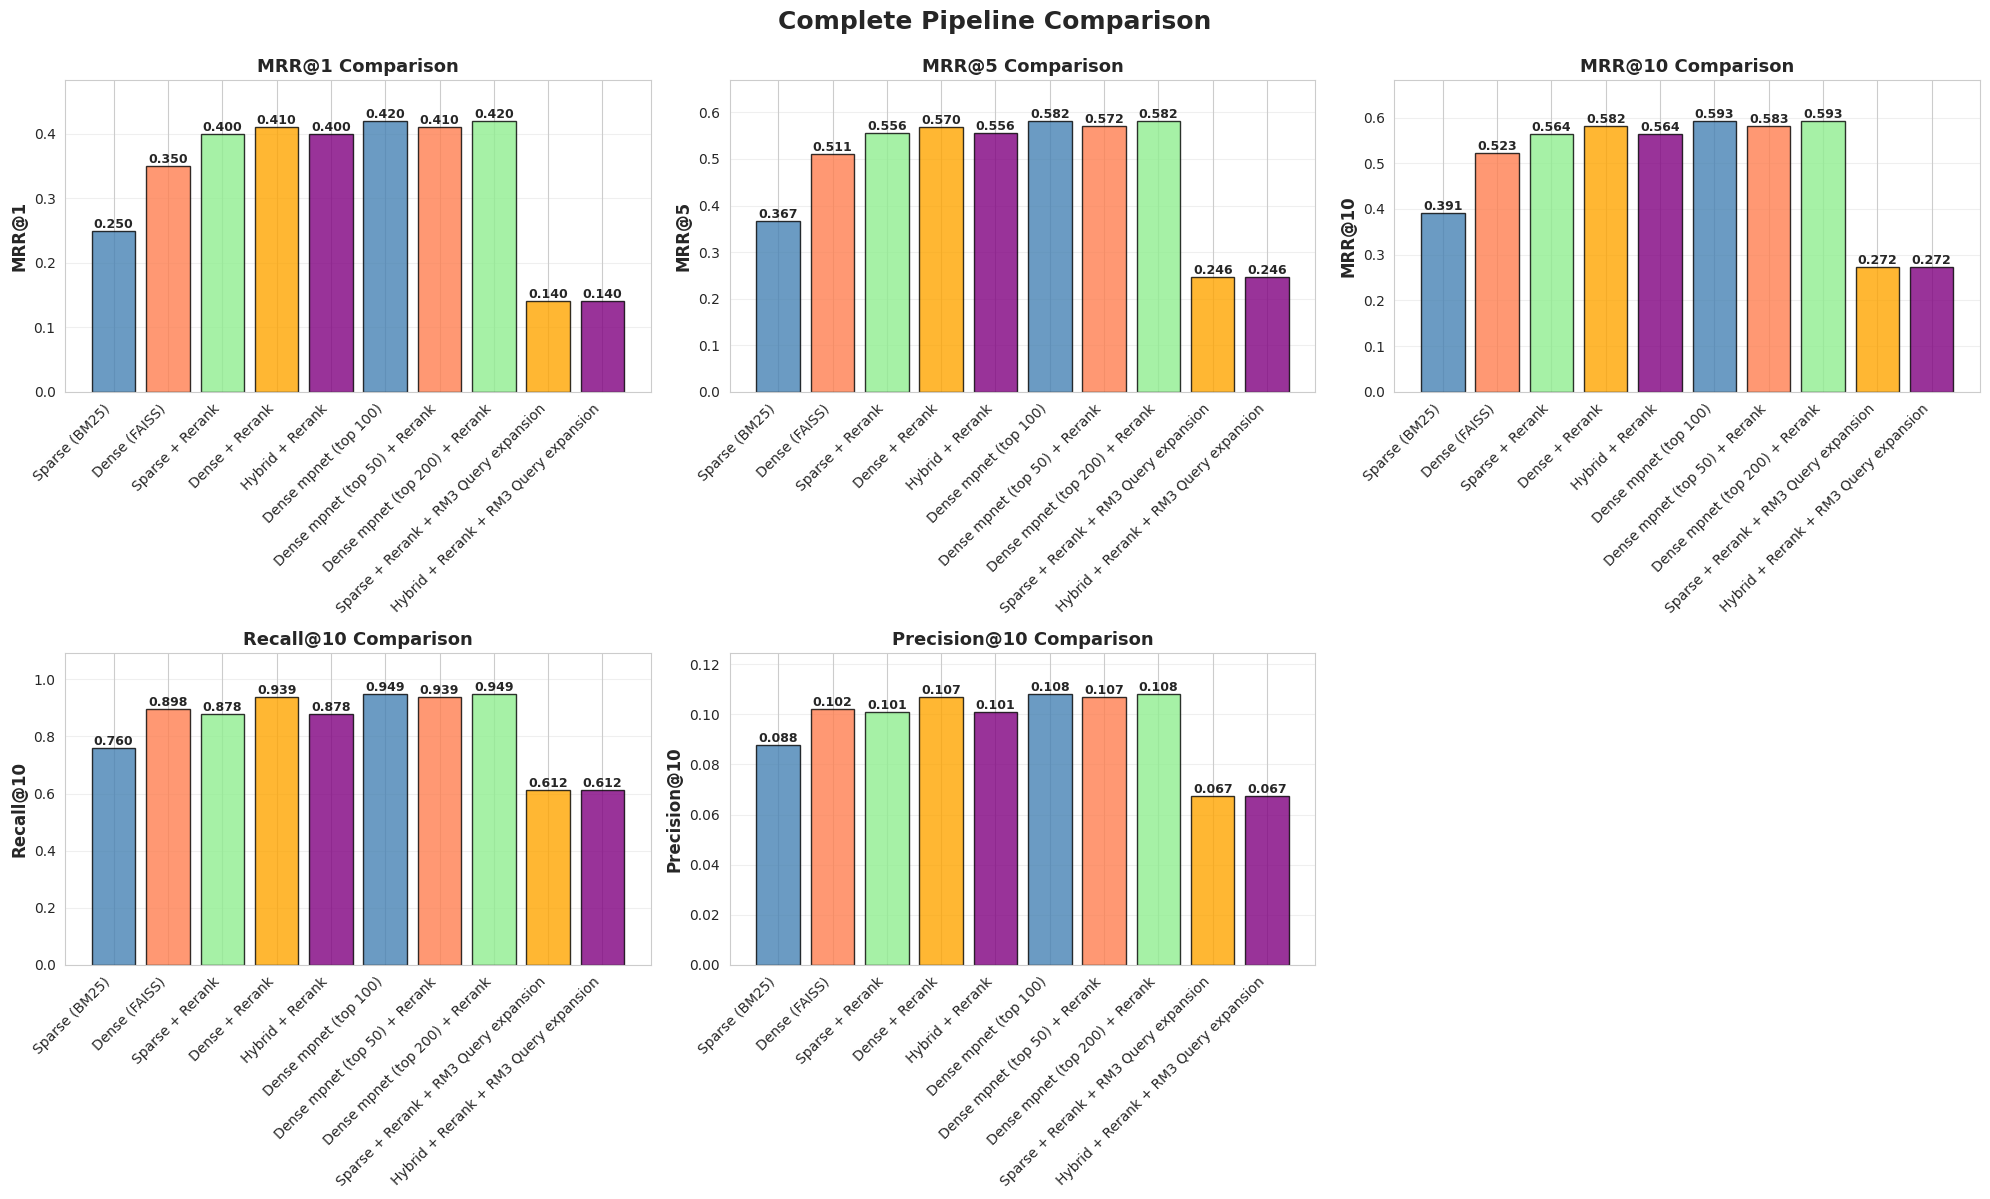

In [61]:
all_metrics = evaluate_pipelines(pipelines, results_dict)
compare_pipelines(pipelines, all_metrics)
